<a href="https://colab.research.google.com/github/theAkhileshRai/ComputerVision/blob/master/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#FineTuning


!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2lm

     |████████████████████████████████| 711.0MB 23kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-gs7odjd5
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-gs7odjd5
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31756 sha256=49298ecbc88fb5dc1f92e082896dfd0d3b14bc0a2483c48c7ef6b20382314b01
  Stored in directory: /tmp/pip-ephem-wheel-cache-lddc0t9w/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l


In [0]:
%matplotlib inline
import d2l
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
import os

npx.set_np()

In [0]:
# Saved in the d2l package for later use
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL+'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')


In [9]:
data_dir = d2l.download_extract('hotdog')

In [10]:
d2l.DATA_URL

'http://d2l-data.s3-accelerate.amazonaws.com/'

In [0]:
train_imgs = gluon.data.vision.ImageFolderDataset(
    os.path.join(data_dir, 'train'))
test_imgs = gluon.data.vision.ImageFolderDataset(
    os.path.join(data_dir, 'test'))

In [31]:
np.array(train_imgs[0][0][0])

array([[152, 141, 119],
       [ 75,  64,  42],
       [135, 122, 103],
       [149, 133, 117],
       [118, 100,  86],
       [100,  91,  76],
       [116, 109,  93],
       [123, 120, 103],
       [ 97,  98,  80],
       [139, 137, 122],
       [ 85,  77,  66],
       [ 53,  38,  33],
       [ 83,  63,  62],
       [ 39,  36,  31],
       [ 29,  27,  30],
       [ 46,  43,  52],
       [ 14,  12,  15],
       [ 39,  37,  24],
       [ 89,  85,  60],
       [137, 129, 108],
       [ 96,  84,  70],
       [ 78,  72,  50],
       [124, 118,  96],
       [143, 135, 116],
       [ 67,  55,  39],
       [106,  94,  82],
       [112,  99,  90],
       [ 73,  62,  56],
       [ 43,  32,  28],
       [108,  98,  99],
       [ 86,  75,  71],
       [ 37,  28,  13],
       [ 85,  75,  50],
       [173, 164, 135],
       [163, 152, 132],
       [ 98,  87,  81],
       [ 49,  36,  43],
       [ 14,  14,  22],
       [ 24,  24,  32],
       [  6,   7,  12],
       [ 17,  17,  19],
       [ 70,  70

In [0]:
hotdogs = [train_imgs[i][0] for i in range(8)]

not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]

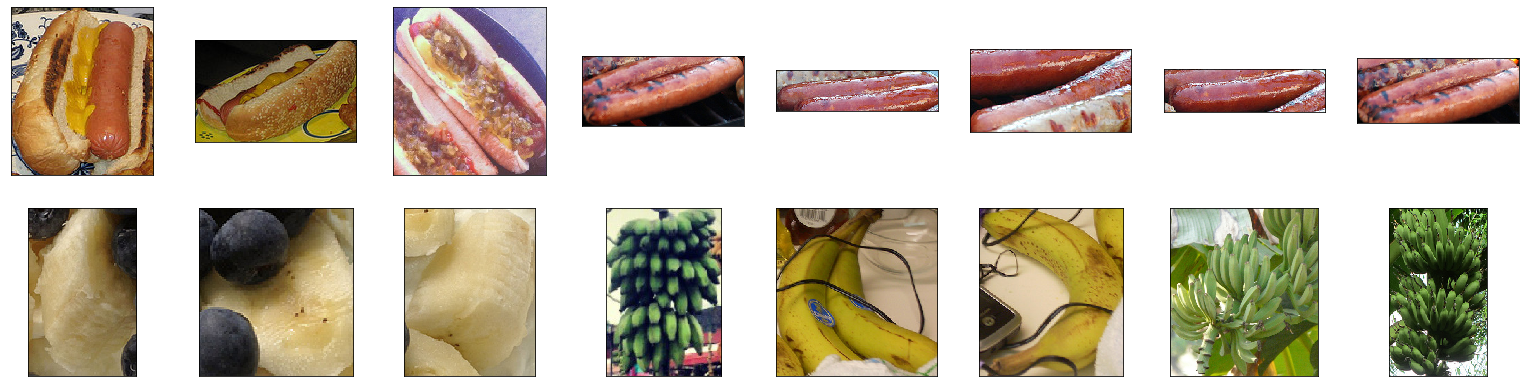

In [61]:
d2l.show_images(hotdogs+not_hotdogs , 2, 8, scale=3.4);

In [0]:
# We specify the mean and variance of the three RGB channels to normalize the
# image channel
normalize = gluon.data.vision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomResizedCrop(224),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor(),
    normalize])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),
    gluon.data.vision.transforms.CenterCrop(224),
    gluon.data.vision.transforms.ToTensor(),
    normalize])

In [70]:
pretrained_net = gluon.model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.output

Dense(512 -> 1000, linear)

In [0]:
finetune_net = gluon.model_zoo.vision.resnet18_v2(classes=2)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
# The model parameters in output will be updated using a learning rate ten
# times greater
finetune_net.output.collect_params().setattr('lr_mult', 10)

In [0]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = gluon.data.DataLoader(
        train_imgs.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gluon.data.DataLoader(
        test_imgs.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': 0.001})
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

loss 0.213, train acc 0.936, test acc 0.922
4.6 examples/sec on [cpu(0)]


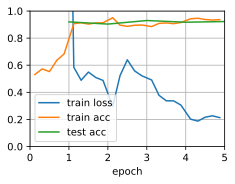

In [73]:
train_fine_tuning(finetune_net, 0.015)

In [0]:
finetune_net.output.collect_params().setattr('lr_mult',10)